<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/notebooks/Result_Visulization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Result Visulization (결과 시각화)

# 1. Library Import

In [39]:
import os, matplotlib, csv, shutil, json
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from IPython.display import Image

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

# 2. 데이터셋 로딩

In [2]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


# 2.1 MNIST Image Array

In [4]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:1000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(1000, 32, 32, 1) (500, 32, 32, 1)


## 2.2 MNIST LABEL Array

In [5]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:1000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(1000, 10) (500, 10)


## 2.3 MNIST figure

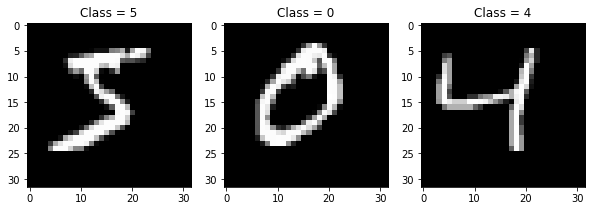

In [6]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

# 3. VGG Model Build

In [7]:
def conv_block_2d(lr_conv, lr_num, par_list, bkn):
        # parameter
        filter_num = par_list[0]
        conv_size = par_list[1]
        conv_act = par_list[2]
        pool_size = par_list[3]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filter_num, conv_size, activation=None, padding='same', 
                                    kernel_initializer='he_normal',
                                    name='block{}_conv{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='block{}_batchnorm{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.Activation(conv_act, name='block{}_activ{}'.format(bkn, i+1))(lr_conv)
        lr_pool = layers.MaxPooling2D(pool_size=pool_size, name='block{}_pool'.format(bkn, i+1))(lr_conv)
        return lr_pool

def output_block(lr_dense, block_num, dens_count, act_func, drop_rate):
    lr_dense = layers.Flatten(name='flatten_layer')(lr_dense)
    for i in range(block_num):
        lr_dense = layers.Dense(dens_count[i], kernel_regularizer=None,
                                activation=act_func, name='classifier_dense_{}'.format(i+1))(lr_dense)
        lr_dense = layers.Dropout(drop_rate, name='classifier_dropout_{}'.format(i+1))(lr_dense)
    return lr_dense

In [8]:
def VGG16_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1), name='input_layer')
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size])
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size])
    block3 = conv_block_2d(block2, 3, [256, conv_size, conv_act, pool_size])
    block4 = conv_block_2d(block3, 3, [512, conv_size, conv_act, pool_size])
    block5 = conv_block_2d(block4, 3, [512, conv_size, conv_act, pool_size])
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act, name='output_layer')(dens)
    model = Model(inputs, outputs)
    return model

In [15]:
def VGG19_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1))
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_2d(block2, 4, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_2d(block3, 4, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_2d(block4, 4, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

In [16]:
network_param_set = {'input_size': 32,
                     'conv_size': 3,
                     'conv_act': 'relu',
                     'pool_size': 2,
                     'dens_num': 2,
                     'dens_count': [1000,500],
                     'dens_act': 'relu',
                     'drop_out': 0.5,
                     'output_count': 10,
                     'output_act': 'softmax'}

In [17]:
model = VGG19_2D(network_param_set)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_batchnorm1 (BatchNorm (None, 32, 32, 64)        256       
_________________________________________________________________
block1_activ1 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_batchnorm2 (BatchNorm (None, 32, 32, 64)        256       
_________________________________________________________________
block1_activ2 (Activation)   (None, 32, 32, 64)        0     

# 4. MNIST Training

In [18]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])

In [19]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('model.h5'),
                                                         monitor='val_loss', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

history = model.fit(x_train1, y_train1, epochs=50, batch_size=32, 
                    validation_data=(x_test1, y_test1),
                    callbacks=callback_list, shuffle=True)

Epoch 1/50
32/32 [==============================] - 11s 67ms/step - loss: 3.5706 - accuracy: 0.0874 - val_loss: 2.3279 - val_accuracy: 0.1000
Epoch 2/50
32/32 [==============================] - 1s 43ms/step - loss: 2.7661 - accuracy: 0.1416 - val_loss: 2.2912 - val_accuracy: 0.1080
Epoch 3/50
32/32 [==============================] - 1s 43ms/step - loss: 2.4316 - accuracy: 0.2041 - val_loss: 2.2246 - val_accuracy: 0.1640
Epoch 4/50
32/32 [==============================] - 1s 43ms/step - loss: 2.2053 - accuracy: 0.2440 - val_loss: 2.1165 - val_accuracy: 0.3300
Epoch 5/50
32/32 [==============================] - 1s 43ms/step - loss: 1.9796 - accuracy: 0.3166 - val_loss: 1.9921 - val_accuracy: 0.4200
Epoch 6/50
32/32 [==============================] - 1s 43ms/step - loss: 1.8117 - accuracy: 0.3551 - val_loss: 1.8496 - val_accuracy: 0.4780
Epoch 7/50
32/32 [==============================] - 1s 43ms/step - loss: 1.6231 - accuracy: 0.4279 - val_loss: 1.7071 - val_accuracy: 0.5520
Epoch 8/50
3

# 5. Train Result

## 5.1. Loss & Accuracy

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

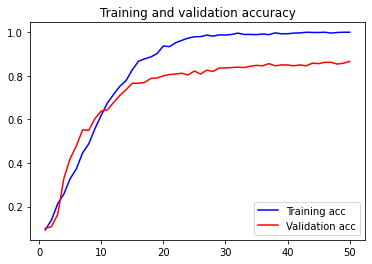

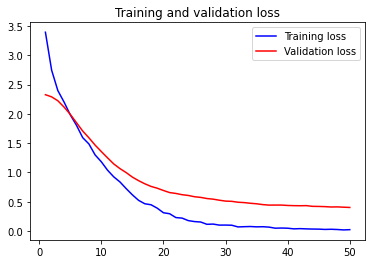

In [21]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##5.2. Prediction Result

(32, 32, 1)


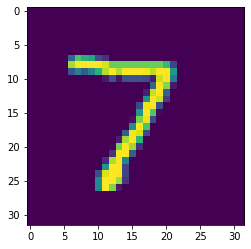

In [22]:
test1 = x_test1[0]
print(test1.shape)
plt.imshow(test1[...,0])

In [27]:
test1p = test1[np.newaxis,...]
score1 = model.predict(test1p)
print(test1p.shape)
print(score1)

new_score1 = []
pred_result = None
for i, i_ in enumerate(score1[0]):
  if i_ < 0.5:
    new_score1.append(0)
  else:
    new_score1.append(1)
    pred_result = i

print(new_score1, '\n# Prediciton Result = ', pred_result)

(1, 32, 32, 1)
[[2.4445073e-05 5.1004763e-06 4.7714680e-06 5.4349118e-07 5.9829695e-06
  2.2206672e-05 5.7355572e-07 9.9989283e-01 3.4462839e-06 4.0216531e-05]]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
# Prediciton Result =  7


## 5.3. Class Attention Map

먼저 GRAD-CAM을 구해주는 함수를 정의한다.

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):

    # 1. 먼저 모델에서 마지막 컨브넷층을 output으로 하고, 테스트 이미지를 input으로 하는 모델을 구성한다.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # 2. 마지막 컨브넷층과 최종 예측결과를 인아웃으로 받는 모델을 구성한다.
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # 그다음, 테스트 이미지에 대한 가장 높은 예측 클래스(여기서는 7)와 마지막 컨브넷층에 대한 그래디언트를 구한다.
    with tf.GradientTape() as tape:
        # 최종 컨브넷층의 결과 추출
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # 예측 클래스 계산
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # 마지막 컨브넷층의 특성맵에 대한 가장 높은 예측 클래스의 그래디언트.
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 가장 높은 예측 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱한다.
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵.
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # 마지막으로 구해진 히트맵을 0 ~ 1 사이값으로 정규화
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

(2, 2)


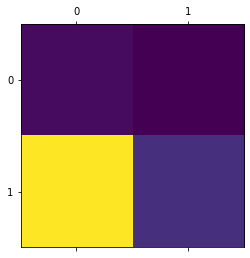

In [85]:
# MNIST 테스트 이미지에 대한 히트맵을 구한다.
heatmap = make_gradcam_heatmap(test1p, model, 'block5_activ4',['block5_pool','flatten_layer'])
print(heatmap.shape)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


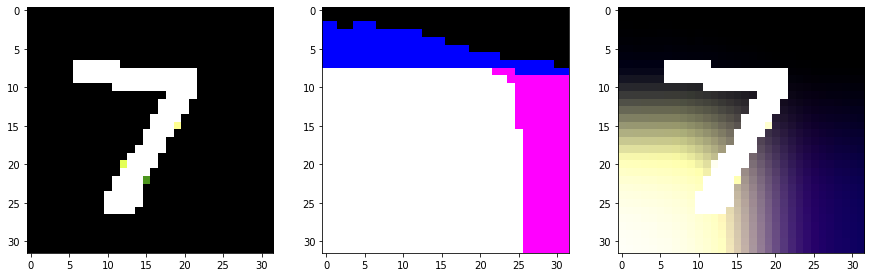

In [84]:
# 히트맵을 0 ~255 사이 값으로 재조정
heatmap = np.uint8(255 * heatmap)

# color map으로 변환
cmap_sel = 'inferno'
new_cm = cm.get_cmap(cmap_sel)

# 컬러맵을 RGB 값으로 변환
cm_colors = new_cm(np.arange(256))[:, :3]
col_heatmap = cm_colors[heatmap]

# RGB 컬러로 변환 컬러맵으로 원본크기에 맞게 히트맵 변환
col_heatmap = keras.preprocessing.image.array_to_img(col_heatmap)
col_heatmap = col_heatmap.resize((32, 32))
col_heatmap = keras.preprocessing.image.img_to_array(col_heatmap)

# 테스트 이미지에 히트맵 오버레이
test1_col = test1 * [0.2989, 0.5870, 0.1140]
superimposed_img = (col_heatmap * 0.005) + test1_col

# 결과 시각화
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(test1_col, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(col_heatmap, cmap=cmap_sel)
plt.subplot(1,3,3)
plt.imshow(superimposed_img)
